In [1]:
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from models import EmotionClassificationModel
from utils import prepare_data 

from transformers import BertTokenizer, BertForSequenceClassification

from tqdm.notebook import tqdm

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
device

device(type='cuda')

## Данные

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
data_path = '/cephfs/home/chepel/MeldProject/MeldCSV/'
num_labels, train_dataloader, test_dataloader, dev_dataloader, test_dataset = prepare_data(tokenizer, 
                                                                                                   data_path, 
                                                                                                   32,
                                                                                                   max_len=128)

In [14]:
model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased',
            num_labels = num_labels
        )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [6]:
train_data = pd.read_csv(data_path + 'train.csv')
test_data = pd.read_csv(data_path + 'test.csv')
dev_data = pd.read_csv(data_path + 'dev.csv')

In [7]:
labels = sorted(list(set(train_data['emotion'])))

In [8]:
label_dict = {}
for i in range(len(labels)):
    label_dict[labels[i]] = i

In [9]:
# красивая confusion matrix
def plot_cm(cm, checkpoint):
    sns.heatmap(cm, annot=True, xticklabels=sorted(labels), yticklabels=sorted(labels))
    plt.ylabel('Истинные метки')
    plt.xlabel('Предсказанные метки')
    plt.title(f'Матрица ошибок для {checkpoint}')
    return plt

In [10]:
# Точность для каждого класса
def calculate_accuracies(cm):
    per_class_accuracies = {}
    for idx,label in enumerate(labels):
        per_class_accuracies[label] = float(f'{cm.diagonal()[idx]/cm.sum(axis=1)[idx]:.2f}')
    return dict(sorted(per_class_accuracies.items(), key=lambda item: item[1]))

## Dummy Classifier

In [26]:
from sklearn.dummy import DummyClassifier

In [27]:
X_train = train_data['utterance']
y_train = train_data['emotion'].replace(label_dict)

X_test = test_data['utterance']
y_test = test_data['emotion'].replace(label_dict)

def classify_easy(dummy_clf):
    
    dummy_clf.fit(X_train, y_train)

    y_preds = dummy_clf.predict(X_test)

    return f1_score(y_test, y_preds, average = 'weighted')

In [28]:
# majority baseline
dummy_clf_freq = DummyClassifier(strategy="most_frequent")
maj_baseline = classify_easy(dummy_clf_freq)

# Случайные бейзлайны
# Stratified - предсказывает по вероятностям классов (напр., Если 50% neutral, то он будет в 50% случаев предсказывать его)
# Unified - исключительно случайный, у всех классов одинаковый вес.
# Я думаю, т.к. у нас несбалансированный датасет, нам лучше использовать stratified

random_states = [15, 42, 68]
score_uniform = []
score_stratified = []
for i in random_states:
    
    dummy_clf_uniform = DummyClassifier(strategy='uniform', random_state=i)
    score_uniform.append(classify_easy(dummy_clf_uniform))
    
    dummy_clf_strat = DummyClassifier(strategy='stratified', random_state=i)
    score_stratified.append(classify_easy(dummy_clf_strat))

print('Majority бейзлайн: {:.2f}'.format(maj_baseline))
print('Случайный бейзлайн: {:.2f}'.format(np.mean(score_uniform)))
print('Случайный бейзлайн (с учетом вероятности классов): {:.2f}'.format(np.mean(score_stratified)))

Majority бейзлайн: 0.31
Случайный бейзлайн: 0.17
Случайный бейзлайн (с учетом вероятности классов): 0.29


# bert-base-uncased_seed-42

In [29]:
checkpoint1 = "bert-base-uncased_seed-42.pt"

In [16]:
def test(test_dataset, answer_model):

    real, pred = [], []
    
    for i in tqdm(range(len(test_dataset))):
        real.append(test_dataset[i][1])
        
        input_ids = test_dataset[i][0]['input_ids']
        attention_mask = test_dataset[i][0]['attention_mask']
        pred.append(int(answer_model(input_ids, attention_mask)))
        
    return real, pred

def use_checkpoint(checkpoint):
    model.load_state_dict(torch.load(checkpoint))
    model.eval()
    answer_model = EmotionClassificationModel(model, device=device)
    real, pred = test(test_dataset, answer_model)
    return real, pred

In [31]:
real1, pred1 = use_checkpoint(checkpoint1)

  0%|          | 0/2610 [00:00<?, ?it/s]

In [32]:
print('F1-score для bert-base-uncased_seed-42.pt: {:.2f}'.format(f1_score(real1, pred1, average='weighted')))

F1-score для bert-base-uncased_seed-42.pt: 0.62


In [33]:
cm_1 = confusion_matrix(real1, pred1, normalize='true')

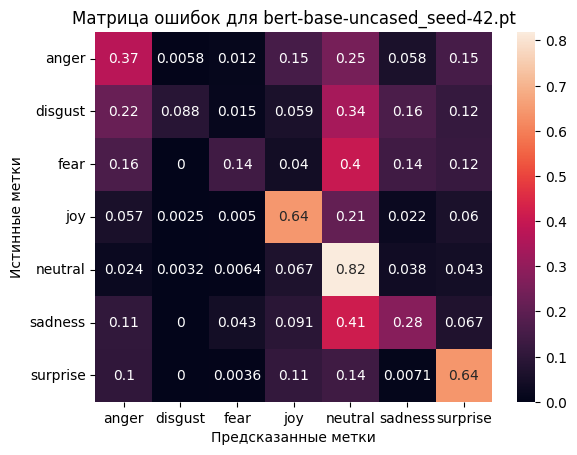

In [35]:
plot_cm(cm_1, checkpoint1).show()

In [37]:
calculate_accuracies(cm_1)

{'disgust': 0.09,
 'fear': 0.14,
 'sadness': 0.28,
 'anger': 0.37,
 'joy': 0.64,
 'surprise': 0.64,
 'neutral': 0.82}

Anger путают с neutral, joy, surprise, Disgust с neutral, anger, sadness, surprise, Fear с neutral, anger, sadness
Joy с neutral, surprise, anger

Neutral с joy (но редко)

Sadness чаще считают neutral, иногда anger, иногда joy(???)

Surprise иногда путает с neutral, joy, anger

## Анализ - более полный

### Disgust
У digust accuracy очень низкая: 0.09, чаще всего он распознается как neutral, anger и sadness.

Правильно угадал всего 6,  распознает только прямо ярко выражено отвращение: 'Oh wait, Joey, you can’t go like that! You **stink**!',
       'It tastes like feet!', '**Ugh**!', 'Oh, **ew**!',
       '**Eww**! Oh, it’s all **dirty**. You should throw this out.', '**Ewww**!'
       
Есть ощущение, что у disgust не особо много отличительных признаков (не считая слов выше). 
- Самая маленькая средняя длина предложений: 4.9

**disgust VS anger**

- Большинство с anger мне самой трудно отнести к disgust: 'You are both idiots.', 'Arghh!!', 'The joke is not funny, and it’s offensive to women, and doctors, and monkeys!', 'Honey, if you wanted to do that, you might as well just gotten him a fish, you know how fish freaked me out!'

- Несколько более очевидных disgust: 'Someone on the subway licked my neck! Licked my neck!!', 'But you will always be the guy who peed on me.' - но отвращение здесь передается не эксплицитно через "ewww"/"dirty", а через глаголы, которые негативны именно в этой ситуации (lick, pee)

**disgust VS neutral**

- Часто короткие: 'Oh, come on.', 'No.', 'No, I don’t.', 'The spitter.'
- Не распознает сарказм: 'Yeah, I’m gonna go to a doctor who went to school in a mini-mall.', 'Hey, y'know what you should do? You should take her back to the 1890's, when that phrase was last used.' (почему это дисгаст?)
- Всегда без !, в основном просто утверждения с точкой.

**disgust VS sadness**

- Здесь, в отличие от anger & neutral, нет коротких реплик: все развернутые предложения: 'You guys, can we please not watch this all right.', 'I also have to find a new video store, a new bank, a new adult bookstore, a new grocery store', 'That’s horrible! Well, you did the right thing man.'
- Много слов с негативной коннотанцией: "horrible", "sick", "hating", "wrong", "die"

### Fear
accuracy 0.14

Верно распознаются только с повторениями: 'I’m, I’m freaking out!',
       'No! No!! It’s me! It’s me! I-I didn’t want to make any noise!',
       "No-no! Don't do it! Don't!",
       'I can’t-I can’t stay here all night, and if I go in there she’s-she’s gonna wanna... do stuff.',
       'Where’s my ring? My dead grandmother’s wedding ring? Where is it? Where is it?',
       "Okay look, don't...don't be mad okay?", 'No-no-no, no!'
- Средняя длина предложений 8.9

**fear VS neutral**
- Хотя здесь тоже есть повторы: "No-no! Big bear! Big bear outside! I think I-I—would you—actually, would you go check on that?", "Wait-wait-wait, do you, do you think, maybe we shouldn’t invite her?", "Umm, about that-that-that last move where the woman tripped you and then pinned you to the floor, what-what-what-what would you do next?'
- 10/20 в форме вопроса: 'Are we okay now?', 'But we-we didn’t have…sex-uh, did we?", "No seriously, y’know the contracts I gave you, did you overnight them?'

**fear VS anger**
- 6/8 восклицания 'Ok, go quick!', "The charity's on fire!", 'Help!'

**fear VS sadness**
- 'I’m so sorry!'
- 'Noo!  Oh, it’s okay, it’s okay, baby, baby, baby.'

### Sadness
accuracy 0.28
Правильно распознаются:
- Начинаются с oh - 17%
- Содержат 'I’m sorry.' - 28%
- Содержат god - 7%

**sadness VS neutral**
- Sadness распознается как neutral чаще, чем как sadness
- И сюда уходят sorry и oh: "Oh, I wish there was something I can do to make you feel better."

**sadness VS anger**
- Почти все либо вопросы, либо восклицания: "Chandler! It happens to lots of guys! You-you-you were probably tired, you had a lot of champagne, don’t worry about it!", 'Don’t I deserve a few tears?!!', 'Come on!'
- Если не вопросы/восклицания, то лексика с ярко выраженной негативной окраской: 'I **broke** it.', 'You can’t **fire** him and **dump** him the same day, he’ll **kill** himself.'

**sadness VS joy**
- Некоторые без контекста и правда неочевидны: 'Oh, my baby!', 'Every moment is precious.', 'Hi!'(это явно принаджлежит Россу, я уверена)
- Многие содержат позитивно окрашенную лексику: 'Two very **good** points, look I’ve known you both a long time, and I’ve never seen either of you one/millionth as **happy** as you’ve been since you’ve got together.', ''I mean you were just… You’re so **incredible**!', 'Oh yeah! Yeah! Don’t worry about me, I’ll be **fine**!'

### Anger
Accuracy 0.37

Правильно угаданные:
- Из 129 правильных 107 восклицания (83%). 24 из 129 содержат вопросы (19%)
- Есть ощущение, что почти все восклицания, и правильные, и неправильные, уходят сюда: 78% от всех определенных как anger - восклицания
- Те, которые не отрицания и не восклицания, в основном содержат слова с ярко выраженным негативным значением: 'And I’m **appalled** for you by the way.', "Y'know what I didn’t wear this suit for a year because you **hated** it. Well, guess what? You’re not my girlfriend anymore so...", 'A little birdie told me something about you wanting to **rip your arm off** and throw it at me.', 'So, you **stole** my joke, and you **stole** my money.'

- Средняя длина предложений, верно распознанных как anger = 9, как joy или как surprise = 8, как neutral = 11

**anger VS neutral**
- Как всегда, многие не содержат в себе негативных слова и непонятно, почему это anger, без контекста: 'It’s Joshua.', 'Yeah. No. No...'
- Интересно, что сюда уходят предложения с okay и all right, даже если это восклицания - видимо, эти слова распознаются как нейтральные: "**Okay**, fine, whatever. Welcome to the building.", '**Okay**, good bye!', '**All right**, bye!', '**All right, all right.**', "All right, I'm going. I'm going.", "**Okay**! Feel free to look, but I’m telling you those contracts are not on this desk.' 
    - в правильно угаданных 3% содержат okay (все с восклицаниями), <1% all right (1 предложение, в котором + восклицание, вопрос и негативное ambush)
    - в распознанных как нейтральные: 9% okay, 8% all right
- Вообще по-хорошему капс должен определять в anger: 'DO YOU?'
- повторения: они были в fear, они есть здесь: 'Did you, did you', "All right, fine, fine, fine, fine, fine, we've got to do something about our little situation here Joey."

**anger VS joy**
- 94% восклицания
- Много коротких: 'Okay-okay!', 'I’m next!', 'I know!', 'Oh yes there is!', 'Hey!', 'Yeah! Got it!', 'Tag!'
- Много с позитивно окрашенной лексикой: '**Love** me, I need **love**!'
- Сарказм: 'Oh yeah, that was great. Thanks to you, the hottest cocktail waitress there is quitting to teach the third grade!', 'Ohh, well, this is just perfect!'
- Интересно: 
    - 'So, you stole my joke, and you stole my money.' - верно определено как anger
    - 'Well, she is going to know that you stole the joke.' - вместо anger определено как joy


**anger VS surprise**
- Вопросы: 65%
- 31% содержит what или why - в то время как в верно угаданных anger в основном общие вопросы
- Опять есть капс, опять не распознан: 'WHAT IS IT?!'

### Joy
Accuracy 0.64
- Много восклицаний, много положительных (good, great, lucky, cute etc)
- В среднем короткие предложения: средняя длина 6.5 (очень много состоящих из 1-2 слов "'Hi!', 'Awww.', 'Thank you', 'You betcha!')

**joy VS neutral**
- Гораздо меньше восклицаний, сюда уходят много с oh и okay

**joy VS surprise**
- Тоже много восклицаний
- 'Oh', 'What', 'Wow'

**joy VS anger**
- Много отрицаний и негативно окрашенных:'Yeah I know, and I bet you thought it would be **weird**. But it’s **not**!', Well now-now you’re just talking **crazy**.', 'I **didn’t!**', несколько "I don’t care!"

### Surprise
- Средняя длина предложений 5.6 
- 'Oh', 'What', "Why", 'Really?!'
- Много восклицаний, вопросов, больше обычного "?!"

**surprise VS neutral**
- Нет восклицаний
- Некоторые без контекста непонятны: 'Hey Chandler, what are you doing here?', Oh, you got the whole night, huh?', 'What is that?'

**surprise VS joy**
- Много коротких: 'Okay!', 'Hey!', 'Fish!', 'Hot coffee!'
- Только 6% не содержат ! (зато содержат положительно окрашенную лексику): 'I’m sorry, it’s just that you’re so incredibly **beautiful**.', '**Wow**, it is **easy**.  Now, I **can** have milk everyday.'

**surprise VS anger**
- 'No!'
- Негативная лексика: "Uh, are you **crazy**? Are you **insane**? If you live with Phoebe, you two are gonna be y'know, live-living together!",'What?! Over a **stupid** room!', 'Shut-out!!'

### Neutral

**surprise VS joy**
- Сюда уходят многие с восклицаниями и словами с положительной коннотацией: 'Yeah. I **really like** his glasses.', '**Great**. He’s doing **great**. Don’t you worry about Chandler.'
- Много "Hi!"


In [38]:
data_to_analyze1 = pd.DataFrame(real1, columns=['Correct'])
data_to_analyze1['Predicted'] = pred1
data_to_analyze1['Utterance'] = test_data['utterance']

In [39]:
data_to_analyze1.query('Correct == 5 & Predicted ==3')['Utterance'].values

array(['Oh, Bob, he was nothing compared to you. I had to bite my lip to keep from screaming your name.',
       'Two very good points, look I’ve known you both a long time, and I’ve never seen either of you one/millionth as happy as you’ve been since you’ve got together.',
       'Well, alright, we already tried feeding her, changing her,  burping her, oh try this one!',
       'Okay, y’know what, you were right, you were right.',
       'Oh yeah! Yeah! Don’t worry about me, I’ll be fine!',
       'I had to have one last kiss, and also-also you said that you were going to leave right after I got on the plane!',
       'I mean we-we told Joey, he cried his eyes out!',
       'Y’know I don’t understand why they didn’t cry. It was a beautiful speech.',
       'Hey!', 'I mean you were just… You’re so incredible!', 'I will!',
       'Hi! It’s me.',
       'Ohh, sweetie!  Hey, I bet you anything that he’s gonna call you again.',
       'Oh please, he’ll be with his real family, the twins an

# 3_context-first-True

In [17]:
checkpoint2 = '3_context-first-True.pt'

model.load_state_dict(torch.load(checkpoint2)['model_state_dict'])
model.eval()
answer_model = EmotionClassificationModel(model, device=device)

real2, pred2 = test(test_dataset, answer_model)

print('F1-score для 3_context-first-True.pt: {:.2f}'.format(f1_score(real2, pred2, average='weighted')))

  0%|          | 0/2610 [00:00<?, ?it/s]

F1-score для 3_context-first-True.pt: 0.59


In [18]:
cm_2 = confusion_matrix(real2, pred2, normalize='true')

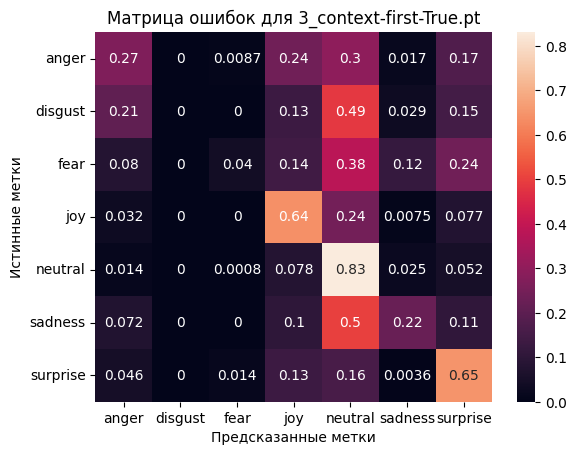

In [19]:
plot_cm(cm_2, checkpoint2).show()

In [20]:
calculate_accuracies(cm_2)

{'disgust': 0.0,
 'fear': 0.04,
 'sadness': 0.22,
 'anger': 0.27,
 'joy': 0.64,
 'surprise': 0.65,
 'neutral': 0.83}

## Заметки

### disgust
Accuracy=0.0
- disgust вообще не предсказывается - даже такой пример, как 'Eww! Oh, it’s all dirty. You should throw this out.' (предсказан neutral)
- чаще всего то, что должно быть disgust, предсказывается как neutral (в основном просто утверждения. сюда, например, уходят короткие "No."
- На втором месте surprise: 60% восклицания, 20% вопросы, в утверждениях есть "oh my god": 'Oh my good God.', 'You know what, where he hugs you and kinda rolls you away and... Oh... my....God.'

### fear
Accuracy=0.04
- Предсказываются повторы:'No! No!! It’s me! It’s me! I-I didn’t want to make any noise!', "No-no! Don't do it! Don't!"
- Чаще всего путается с neutral и sadness
- fear VS neutral:
    - Большинство обычные утверждения, довольно много вопросов.
- fear VS sadness: 
   - 30% вопросы, есть восклицание с 'I'm so sorry' - sorry харакетрно для sadness
   - Должен был, но не распознал повторы:'I’m, I’m freaking out!', "Okay look, don't...don't be mad okay?"
   
### sadness
Accuracy=0.22
- В основном утверждения, восклицания 10%, вопросы 4%
- 20% начинаются с 'oh'
- 30% содержат "I'm sorry'
- Чаще всего путается с neutral (50% всех предсказаний) и surprise - остальные редко.
- Sadness VS surprise: 27% содержат вопросы с what/why
- Sadness VS anger: 87% содержат восклицания, остальные - вопросы.

### anger
Accuracy=0.27
- Чаще всего путается с neutral, joy, surprise 
- В этой модели чаще предсказывает anger как neutral, чем как anger
- 87% верно предсказанных anger - восклицания

### joy
Accuracy=0.64

### surprise
Accuracy=0.65

### neutral
Accuracy=0.83

In [21]:
data_to_analyze2 = pd.DataFrame(real2, columns=['Correct'])
data_to_analyze2['Predicted'] = pred2
data_to_analyze2['Utterance'] = test_data['utterance']

In [45]:
len(data_to_analyze2.query('Correct == 0 & Predicted == 0')['Utterance'].values)

92

In [ ]:
# ## длина
# def calculate_correct_length(label):
#     length = np.mean([len(i.split()) for i in data_to_analyze1.query(f'Correct == {label}')['Utterance'].values])
#     return length

# def calculate_correct_not_predicted_length(label):
#     length = np.mean([len(i.split()) for i in data_to_analyze1.query(f'Correct == {label} & Predicted != {label}')['Utterance'].values])
#     return length

# def calculate_wrong_preds(labels):
#     length = np.mean([len(i.split()) for i in data_to_analyze1.query(f'Correct == {label} & Predicted != {label}')['Utterance'].values])
#     return length